# 5G NR PUSCH Tutorial

This notebook provides an introduction to Sionna's [5G New Radio (NR) module](https://nvlabs.github.io/sionna/api/nr.html) and, in particular, the [physical uplink shared channel (PUSCH)](https://nvlabs.github.io/sionna/api/nr.html#pusch). This module provides implementations of a small subset of the physical layer functionalities as described in the 3GPP specifications [38.211](https://portal.3gpp.org/desktopmodules/Specifications/SpecificationDetails.aspx?specificationId=3213), [38.212](https://portal.3gpp.org/desktopmodules/Specifications/SpecificationDetails.aspx?specificationId=3214) and [38.214](https://portal.3gpp.org/desktopmodules/Specifications/SpecificationDetails.aspx?specificationId=3216). 


You will

- Get an understanding of the different components of a PUSCH configuration, such as the carrier, DMRS, and transport block,
- Learn how to rapidly simulate PUSCH transmissions for multiple transmitters,
- Modify the PUSCHReceiver to use a custom MIMO Detector.

## Table of Contents
* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [A "Hello World!" Example](#A-Hello-World-Example)
* [Carrier Configuration](#Carrier-Configuration)
* [Understanding the DMRS Configuration](#Understanding-the-DMRS-Configuration)
    * [Configuring Multiple Layers](#Configuring-Multiple-Layers)
    * [Controlling the Number of DMRS Symbols in a Slot](#Controlling-the-Number-of-DMRS-Symbols-in-a-Slot)
    * [How to control the number of available DMRS ports?](#How-to-control-the-number-of-available-DMRS-ports?)
* [Transport Blocks and MCS](#Transport-Blocks-and-MCS)
* [Looking into the PUSCHTransmitter](#Looking-into-the-PUSCHTransmitter)
* [Components of the PUSCHReceiver](#Components-of-the-PUSCHReceiver)
* [End-to-end PUSCH Simulations](#End-to-end-PUSCH-Simulations)


## GPU Configuration and Imports

In [13]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# tahtan
# Import Sionna
import sys
sys.path.append('../')
import sionna

# try:
#     import sionna
# except ImportError as e:
#     # Install Sionna if package is not already installed
#     import os
#     os.system("pip install sionna")
#     import sionna

import tensorflow as tf
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

sionna.config.seed = 42 # Set seed for reproducible results

# Load the required Sionna components
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver, CarrierConfig, PUSCHDMRSConfig, TBConfig
from sionna.nr.utils import generate_prng_seq
from sionna.channel import AWGN, RayleighBlockFading, OFDMChannel, TimeChannel, time_lag_discrete_time_channel
from sionna.channel.utils import * 
from sionna.channel.tr38901 import Antenna, AntennaArray, UMi, UMa, RMa, TDL, CDL
from sionna.channel import gen_single_sector_topology as gen_topology
from sionna.utils import compute_ber, ebnodb2no, sim_ber, array_to_hash, create_timestamped_folders, b2b, f2f
from sionna.ofdm import KBestDetector, LinearDetector, ResourceGrid, MaximumLikelihoodDetector
from sionna.mimo import StreamManagement


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
import json

## A Hello World Example

Let us start with a simple "Hello, World!" example in which we will simulate PUSCH transmissions from a single transmitter to a single receiver over an AWGN channel.

In [22]:
class MyPUSCHConfig(PUSCHConfig):
    def __init__(self):
        super().__init__(
            carrier_config=CarrierConfig(
                n_cell_id=500,
                cyclic_prefix="normal",
                subcarrier_spacing=30,
                n_size_grid=273,
                n_start_grid=0,
                slot_number=4,
                frame_number=0
            ),
            pusch_dmrs_config=PUSCHDMRSConfig(
                config_type=1,
                length=1,
                additional_position=1,
                dmrs_port_set=[0],
                n_id=0,
                n_scid=0,
                num_cdm_groups_without_data=2,
                type_a_position=2
            ),
            tb_config=TBConfig(
                channel_type='PUSCH',
                n_id=20,
                mcs_table=1,
                mcs_index=0
            ),
            mapping_type='A',
            n_size_bwp=104,
            n_start_bwp=0,
            num_layers=1,
            num_antenna_ports=1,
            precoding='non-codebook',
            tpmi=0,
            transform_precoding=False,
            n_rnti=2001,
            symbol_allocation=[0,14]
        )

In [ ]:
# Create a PUSCH configuration with default settings
pusch_config = PUSCHConfig()

pusch_config.mapping_type = 'A'
pusch_config.n_size_bwp = 104
pusch_config.n_start_bwp = 0
pusch_config.num_layers = 1
pusch_config.num_antenna_ports = 1
pusch_config.precoding = 'non-codebook'
pusch_config.tpmi = 0
pusch_config.transform_precoding = False
pusch_config.n_rnti = 2001
pusch_config.symbol_allocation = [0,14]

pusch_config.carrier.n_cell_id = 500
pusch_config.carrier.cyclic_prefix = "normal"
pusch_config.carrier.subcarrier_spacing = 30
pusch_config.carrier.n_size_grid = 273
pusch_config.carrier.n_start_grid = 0
pusch_config.carrier.slot_number = 4
pusch_config.carrier.frame_number = 0

pusch_config.dmrs.config_type = 1
pusch_config.dmrs.length = 1
pusch_config.dmrs.additional_position = 1
pusch_config.dmrs.dmrs_port_set = [0]
pusch_config.dmrs.n_id = 0
pusch_config.dmrs.n_scid = 0
pusch_config.dmrs.num_cdm_groups_without_data = 2
pusch_config.dmrs.type_a_position = 2

pusch_config.tb.channel_type = 'PUSCH'
pusch_config.tb.n_id = 20
pusch_config.tb.mcs_table = 1
pusch_config.tb.mcs_index = 9


# Instantiate a PUSCHTransmitter from the PUSCHConfig
pusch_transmitter = PUSCHTransmitter(pusch_config)

# Create a PUSCHReceiver using the PUSCHTransmitter
pusch_receiver = PUSCHReceiver(pusch_transmitter)

# AWGN channel
channel = AWGN()

# Simulate transmissions over the AWGN channel
batch_size = 16
no = 0.1 # Noise variance

x, b = pusch_transmitter(batch_size) # Generate transmit signal and info bits

y = channel([x, no]) # Simulate channel output

b_hat = pusch_receiver([y, no]) # Recover the info bits

# Compute BER
print("BER:", compute_ber(b, b_hat).numpy())

BER: 0.0


Although the above code snippet seems rather simple, you have actually carried out standard-compliant simulations of the NR PUSCH!

To better understand what is actually going on under the hood, we can inspect the OFDM resource grid that is generated by the transmitter with the following command:

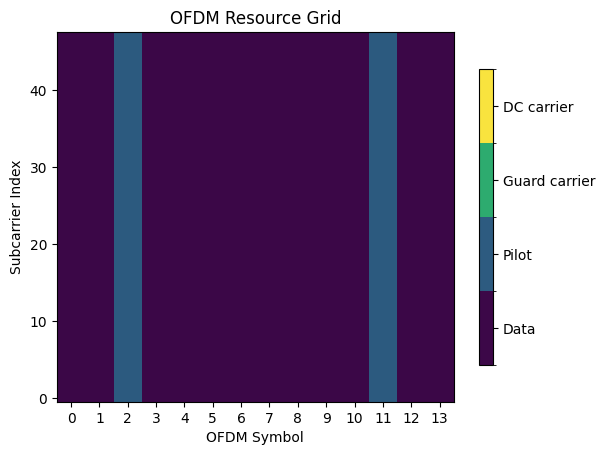

In [4]:
pusch_transmitter.resource_grid.show();

The above figure tells us that we are simulating a slot of 14 OFDM symbols spanning 48 subcarriers, which correspond to four physical resource blocks (PRBs) in 5G terminology. The third OFDM symbol is reserved for pilot transmissions, so-called demodulation reference signals (DMRS), and the rest is used for data. 

## Carrier Configuration

When you create a PUSCHConfig instance, it automatically creates a CarrierConfig instance with default settings.
You can inspect this configuration with the following command:

In [5]:
pusch_config.carrier.show()

Carrier Configuration
cyclic_prefix : normal
cyclic_prefix_length : 2.3437500000000002e-06
frame_duration : 0.01
frame_number : 0
kappa : 64.0
mu : 1
n_cell_id : 500
n_size_grid : 273
n_start_grid : 0
num_slots_per_frame : 20
num_slots_per_subframe : 2
num_symbols_per_slot : 14
slot_number : 4
sub_frame_duration : 0.001
subcarrier_spacing : 30
t_c : 5.086263020833334e-10
t_s : 3.2552083333333335e-08



## Understanding the DMRS Configuration

We can learn more about the structure of the resoure grid by having a look at the pilot pattern in the next section.

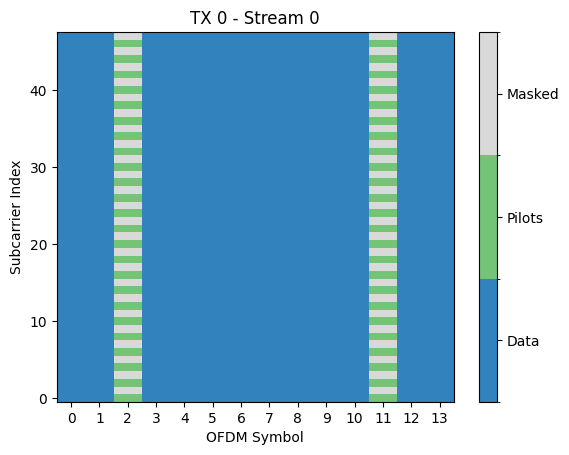

In [6]:
pusch_transmitter.pilot_pattern.show();

From the figure above, we can see that there is a single transmitter sending a single stream (or so-called layer).
DMRS are only sent on even subcarriers while odd subcarriers are masked, i.e., blocked for data transmission.
This corresponds to the DMRS Configuration Type 1 with the parameter `NumCDMGroupsWithoutData` set to 2. We will explain what that means later.

In 5G NR, one can configure many different pilot patterns to adapt to different channel conditions and to allow for spatial multiplexing of up to twelve layers. Each transmitted layer is identified by a DMRS port, i.e., a distinct pilot pattern. In our running example, the transmitter uses the DMRS port 0.

With the current PUSCH configuration, four different DMRS ports 0,1,2,3 are available.
This can be verified with the following command:

In [7]:
pusch_config.dmrs.allowed_dmrs_ports

[0, 1, 2, 3]

In [8]:
pusch_config.dmrs.show()

PUSCH DMRS Configuration
additional_position : 1
allowed_dmrs_ports : [0, 1, 2, 3]
beta : 1.4142135623730951
cdm_groups : [0]
config_type : 1
deltas : [0]
dmrs_port_set : [0]
length : 1
n_id : [0, 0]
n_scid : 0
num_cdm_groups_without_data : 2
type_a_position : 2
w_f : [[1]
 [1]]
w_t : [[1]
 [1]]



In [9]:
pusch_config.show()

Carrier Configuration
cyclic_prefix : normal
cyclic_prefix_length : 2.3437500000000002e-06
frame_duration : 0.01
frame_number : 0
kappa : 64.0
mu : 1
n_cell_id : 500
n_size_grid : 273
n_start_grid : 0
num_slots_per_frame : 20
num_slots_per_subframe : 2
num_symbols_per_slot : 14
slot_number : 4
sub_frame_duration : 0.001
subcarrier_spacing : 30
t_c : 5.086263020833334e-10
t_s : 3.2552083333333335e-08

PUSCH Configuration
dmrs_grid : shape (1, 48, 14)
dmrs_grid_precoded : shape ()
dmrs_mask : shape (48, 14)
dmrs_symbol_indices : [2, 11]
frequency_hopping : neither
l : [2, 11]
l_0 : 2
l_bar : [2, 11]
l_d : 14
l_prime : [0]
l_ref : 0
mapping_type : A
n : shape (12,)
n_rnti : 2001
n_size_bwp : 4
n_start_bwp : 0
num_antenna_ports : 1
num_coded_bits : 1152
num_layers : 1
num_ov : 0
num_res_per_prb : 144
num_resource_blocks : 4
num_subcarriers : 48
precoding : non-codebook
precoding_matrix : None
symbol_allocation : [0, 14]
tb_size : 224
tpmi : 0
transform_precoding : False

PUSCH DMRS Configu

## Transport Blocks and MCS

The modulation and coding scheme (MCS) is set in 5G NR via the MCS index and MCS table which are properties of transport block configuration [TBConfig](https://nvlabs.github.io/sionna/api/nr.html#sionna.nr.TBConfig). When you create an instance of ``PUSCHConfig``, a default instance of ``TBConfig`` is created. It can be accessed via the following command:

In [10]:
pusch_config.tb.show()

Transport Block Configuration
channel_type : PUSCH
mcs_index : 2
mcs_table : 1
n_id : 20
num_bits_per_symbol : 2
target_coderate : 0.1884765625
tb_scaling : 1.0



You can see that the current MCS Table is 1 and the MCS index is 14. Looking at the corresponding table in the API documentation of [TBConfig](https://nvlabs.github.io/sionna/api/nr.html#sionna.nr.TBConfig), you can see that we should have  a 16QAM modulation (i.e., 4 bits per symbol) and a target coderate of 553/1024=0.54 which matches the values above. The data scrambling ID $n_\text{ID}$ is set to `None` which implies that the physical layer cell id $N^\text{cell}_\text{ID}$ will be used instead.

For more details about how the transportblock encoding/decoding works, we refer to the API documentation of the [TBEncoder](https://nvlabs.github.io/sionna/api/nr.html#sionna.nr.TBEncoder).

## Looking into the PUSCHTransmitter

We have used the ``PUSCHTransmitter`` class already multiple times without speaking about what it actually does. In short, it generates for every configured transmitter a batch of random information bits of length ``pusch_config.tb_size`` and outputs either a frequency to time-domain representation of the transmitted OFDM waveform from each of the antenna ports of each transmitter.

However, under the hood it implements the sequence of layers shown in the following figure: 

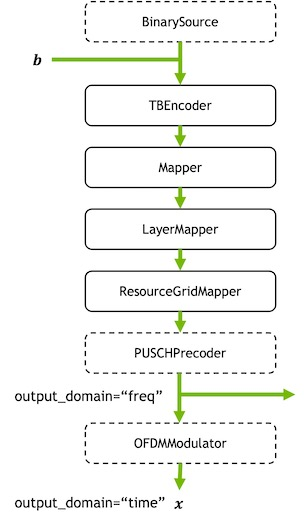

Information bits are either randomly generated or provided as input and then encoded into a transport block by the [TBEncoder](https://nvlabs.github.io/sionna/api/nr.html#sionna.nr.TBEncoder). The encoded bits are then mapped to QAM constellation symbols by the [Mapper](https://nvlabs.github.io/sionna/api/mapping.html#sionna.mapping.Mapper). The [LayerMapper](https://nvlabs.github.io/sionna/api/nr.html#sionna.nr.LayerMapper) splits the modulated symbols into different layers which are then mapped onto OFDM resource grids by the [ResourceGridMapper](https://nvlabs.github.io/sionna/api/ofdm.html#sionna.ofdm.ResourceGridMapper). If precoding is enabled in the [PUSCHConfig](https://nvlabs.github.io/sionna/api/nr.html#sionna.nr.PUSCHConfig), the resource grids are further precoded by the [PUSCHPrecoder](https://nvlabs.github.io/sionna/api/nr.html#sionna.nr.PUSCHPrecoder) so that there is one for each transmitter and antenna port. If ``output_domain`` equals “freq”, these are the ouputs 
x
. If ``output_domain`` is chosen to be “time”, the resource grids are transformed into time-domain signals by the [OFDMModulator](https://nvlabs.github.io/sionna/api/ofdm.html#sionna.ofdm.OFDMModulator).

Let us configure a ``PUSCHTransmitter`` from a list of two ``PUSCHConfig`` and inspect the output shapes: 

In [11]:
batch_size = 32
x, b = pusch_transmitter(batch_size)

# b has shape [batch_size, num_tx, tb_size]
print("Shape of b:", b.shape)

# x has shape [batch_size, num_tx, num_tx_ant, num_ofdm_symbols, num_subcarriers]
print("Shape of x:", x.shape)

Shape of b: (32, 1, 224)
Shape of x: (32, 1, 1, 14, 48)


If you want to transmit a custom payload, you simply need to deactive the ``return_bits`` flag when creating the transmitter:

In [12]:
x_2 = PUSCHTransmitter(pusch_config, return_bits=False)(b)
assert np.array_equal(x, x_2) # Check that we get the same output for the payload b generated above

In [13]:
source_bits = generate_prng_seq(pusch_config.tb_size, 1234).reshape(1,1,-1)
tx_IQ = PUSCHTransmitter(pusch_config, return_bits=False)(source_bits)

In [14]:
print(array_to_hash(source_bits, '/tmp/source_bits.txt'))
print(array_to_hash(tx_IQ, '/tmp/transmited_IQ.txt'))

92312fe668d9be9ae93dbe9e7ebbcae7  /tmp/source_bits.txt
2b4811fd786242762db074f433fe8c84  /tmp/transmited_IQ.txt


In [15]:
# pusch_transmitter = PUSCHTransmitter(pusch_config, return_bits=False)
# pusch_transmitter._pusch_configs[0].carrier.slot_number = 4
# print(array_to_hash(pusch_transmitter(source_bits), '/tmp/transmited_IQ.txt'))

## Components of the PUSCHReceiver

The [PUSCHReceiver](https://nvlabs.github.io/sionna/api/nr.html#sionna.nr.PUSCHReceiver) is the counter-part to the [PUSCHTransmitter](https://nvlabs.github.io/sionna/api/nr.html#sionna.nr.PUSCHTransmitter) as it *simply* recovers the transmitted information bits from received waveform. It combines multiple processing blocks in a single layer as shown in the following figure:

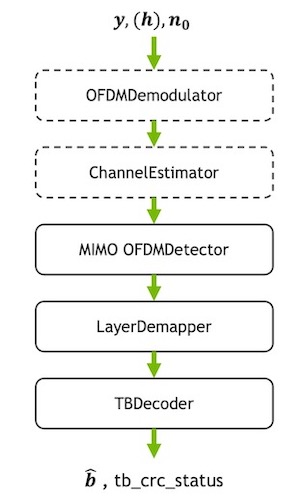

If the ``input_domain`` equals “time”, the inputs $\mathbf{y}$
 are first transformed to resource grids with the [OFDMDemodulator](https://nvlabs.github.io/sionna/api/ofdm.html#sionna.ofdm.OFDMModulator). Then channel estimation is performed, e.g., with the help of the [PUSCHLSChannelEstimator](https://nvlabs.github.io/sionna/api/nr.html#sionna.nr.PUSCHLSChannelEstimator). If ``channel_estimator`` is chosen to be “perfect”, this step is skipped and the input $\mathbf{h}$ is used instead. Next, MIMO detection is carried out with an arbitrary [OFDMDetector](https://nvlabs.github.io/sionna/api/ofdm.html#sionna.ofdm.OFDMDetector). The resulting LLRs for each layer are then combined to transport blocks with the help of the [LayerDemapper](https://nvlabs.github.io/sionna/api/nr.html#sionna.nr.LayerDemapper). Finally, the transport blocks are decoded with the [TBDecoder](https://nvlabs.github.io/sionna/api/nr.html#sionna.nr.TBDecoder).
 
If we instantiate a ``PUSCHReceiver`` as done in the next cell, default implementations of all blocks as described in the [API documentation](https://nvlabs.github.io/sionna/api/nr.html#sionna.nr.PUSCHReceiver) are used.  


In [16]:
pusch_receiver = PUSCHReceiver(pusch_transmitter)
pusch_receiver._mimo_detector

We can also provide custom implementations for each block by providing them as keyword arguments during initialization.
In the folllwing code snippet, we first create an instance of the [KBestDetector](https://nvlabs.github.io/sionna/api/ofdm.html#sionna.ofdm.KBestDetector), which is then used as MIMO detector in the ``PUSCHReceiver``.

In [17]:
# Create a StreamManagement instance
rx_tx_association = np.ones([1, pusch_transmitter.resource_grid.num_tx], bool)
stream_management = StreamManagement(rx_tx_association,
                                     pusch_config.num_layers)

# Get relevant parameters for the detector
num_streams = pusch_transmitter.resource_grid.num_tx \
              * pusch_transmitter.resource_grid.num_streams_per_tx

k = 16 # Number of canditates for K-Best detection 

k_best = KBestDetector("bit", num_streams, k,
                       pusch_transmitter.resource_grid,
                       stream_management,
                       "qam", pusch_config.tb.num_bits_per_symbol)

# Create a PUSCHReceiver using the KBest detector
pusch_receiver = PUSCHReceiver(pusch_transmitter, mimo_detector=k_best)

/workspaces/sionna/examples/../sionna/mimo/detection.py:1040: UserWarning: KBestDetector: The provided value of k=16 is larger than the possible maximum number of paths. It has been set to k=4.
  warnings.warn(msg)


In [18]:
# sm = StreamManagement(np.array([[1]]), 1)
# rg = ResourceGrid(num_ofdm_symbols=1,
#                 fft_size=1024,
#                 subcarrier_spacing=15e3)
# tdl = TDL("A", 100e-9, 3.5e9)

# # Generate CIR
# cir = tdl(batch_size=1, num_time_steps=1, sampling_frequency=rg.bandwidth)

# # Generate OFDM channel from CIR
# frequencies = subcarrier_frequencies(rg.fft_size, rg.subcarrier_spacing)
# h_freq = tf.squeeze(cir_to_ofdm_channel(frequencies, *cir, normalize=True))

# # Generate time channel from CIR
# l_min, l_max = time_lag_discrete_time_channel(rg.bandwidth)
# h_time = cir_to_time_channel(rg.bandwidth, *cir, l_min=l_min, l_max=l_max, normalize=True)

# # Generate OFDM channel from time channel
# h_freq_hat = tf.squeeze(time_to_ofdm_channel(h_time, rg, l_min))

# # Visualize results
# plt.figure()
# plt.plot(np.real(h_freq), "-")
# plt.plot(np.real(h_freq_hat), "--")
# plt.plot(np.imag(h_freq), "-")
# plt.plot(np.imag(h_freq_hat), "--")
# plt.xlabel("Subcarrier index")
# plt.ylabel(r"Channel frequency response")
# plt.legend(["OFDM Channel (real)", "OFDM Channel from time (real)", "OFDM Channel (imag)", "OFDM Channel from time (imag)"])

Next, we test if this receiver works over a simple Rayleigh block fading channel:

In [19]:
num_rx_ant = 8
rayleigh = RayleighBlockFading(num_rx=1,
                               num_rx_ant=num_rx_ant,
                               num_tx=pusch_transmitter.resource_grid.num_tx,
                               num_tx_ant=pusch_config.num_antenna_ports)

channel = OFDMChannel(rayleigh,
                      pusch_transmitter.resource_grid,
                      add_awgn=True,
                      normalize_channel=True)

x, b = pusch_transmitter(32)
no = 0.1
y = channel([x, no])
b_hat = pusch_receiver([y, no])
print("BER:", compute_ber(b, b_hat).numpy())

I0000 00:00:1739268142.110040    2291 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


BER: 0.0


In [20]:
pusch_receiver._channel_estimator, pusch_receiver._mimo_detector

(<sionna.nr.pusch_channel_estimation.PUSCHLSChannelEstimator at 0x7e36499c0f90>,
 <sionna.ofdm.detection.KBestDetector at 0x7e3658130250>)

In [21]:
with open('pusch_config.txt','w') as f:
    pusch_config.show(f)

## End-to-end PUSCH Simulations

We will now implement a end-to-end Keras model that is capable of running PUSCH simulations for many different configurations.
You can use it as a boilerplate template for your own experiments.

In [22]:
# We need to enable sionna.config.xla_compat before we can use
# tf.function with jit_compile=True.
# See https://nvlabs.github.io/sionna/api/config.html#sionna.Config.xla_compat
sionna.config.xla_compat=True

class Simulation(tf.keras.layers.Layer):
    """Simulate PUSCH transmissions over a 3GPP 38.901 model.
    
    This model runs BER simulations for a multiuser MIMO uplink channel
    compliant with the 5G NR PUSCH specifications. 
    You can pick different scenarios, i.e., channel models, perfect or
    estimated CSI, as well as different MIMO detectors (LMMSE or KBest).
    You can chosse to run simulations in either time ("time") or frequency ("freq")
    domains and configure different user speeds.
    
    Parameters
    ----------
    scenario : str, one of ["umi", "uma", "rma"]
        3GPP 38.901 channel model to be used
        
    perfect_csi : bool
        Determines if perfect CSI is assumed or if the CSI is estimated
        
    domain :  str, one of ["freq", "time"]
        Domain in which the simulations are carried out.
        Time domain modelling is typically more complex but allows modelling
        of realistic effects such as inter-symbol interference of subcarrier
        interference due to very high speeds.
    
    detector : str, one of ["lmmse", "kbest"]
        MIMO detector to be used. Note that each detector has additional
        parameters that can be configured in the source code of the _init_ call.
        
    speed: float
        User speed (m/s)
        
    Input
    -----
    batch_size : int
        Number of simultaneously simulated slots
        
    ebno_db : float
        Signal-to-noise-ratio
    
    Output
    ------
    b : [batch_size, num_tx, tb_size], tf.float
        Transmitted information bits
        
    b_hat : [batch_size, num_tx, tb_size], tf.float
        Decoded information bits   
    """
    def __init__(self, mode=1):  
        super().__init__()
        # Create a PUSCH configuration with default settings
        pusch_config = PUSCHConfig()

        pusch_config.mapping_type = 'A'
        pusch_config.n_size_bwp = 4
        pusch_config.n_start_bwp = 0
        pusch_config.num_layers = 1
        pusch_config.num_antenna_ports = 1
        pusch_config.precoding = 'non-codebook'
        pusch_config.tpmi = 0
        pusch_config.transform_precoding = False
        pusch_config.n_rnti = 2001

        pusch_config.carrier.cyclic_prefix = "normal"
        pusch_config.carrier.subcarrier_spacing = 30
        pusch_config.carrier.n_cell_id = 500
        pusch_config.carrier.n_size_grid = 273
        pusch_config.carrier.n_start_grid = 0
        # pusch_config.carrier.slot_number = 4

        pusch_config.dmrs.config_type = 1
        pusch_config.dmrs.length = 1
        pusch_config.dmrs.additional_position = 1
        pusch_config.dmrs.dmrs_port_set = [0]
        pusch_config.dmrs.n_id = 0
        pusch_config.dmrs.n_scid = 0
        pusch_config.dmrs.num_cdm_groups_without_data = 2
        pusch_config.dmrs.type_a_position = 2

        pusch_config.tb.channel_type = 'PUSCH'
        pusch_config.tb.n_id = 20
        pusch_config.tb.mcs_table = 1
        pusch_config.tb.mcs_index = 2

        self._pusch_config = pusch_config
        # Instantiate a PUSCHTransmitter from the PUSCHConfig
        self._pusch_transmitter = PUSCHTransmitter(pusch_config)
                
        
        rx_tx_association = np.ones([1, 1], bool)
        stream_management = StreamManagement(rx_tx_association,1)
        
        
     

        detector = MaximumLikelihoodDetector(output="bit",
                                             demapping_method="maxlog",
                                             resource_grid=self._pusch_transmitter.resource_grid,
                                             stream_management=stream_management,
                                             constellation_type="qam",
                                             num_bits_per_symbol=pusch_config.tb.num_bits_per_symbol)
            
        if mode==0:
            self._pusch_receiver = PUSCHReceiver(self._pusch_transmitter,
                                                 mimo_detector=detector,
                                                 channel_estimator="perfect")
        else:
            self._pusch_receiver = PUSCHReceiver(self._pusch_transmitter)
        
        # Configure antenna arrays
        ut_antenna = Antenna(polarization="single",
                     polarization_type="V",
                     antenna_pattern="38.901",
                     carrier_frequency=2.55e9)

        bs_array = AntennaArray(num_rows=1,
                                num_cols=4,
                                polarization="dual",
                                polarization_type="cross",
                                antenna_pattern="38.901",
                                carrier_frequency=2.55e9)
        cdl = CDL("C", 100e-9, 2.55e9, ut_antenna, bs_array, "uplink", min_speed=10)

        self._channel = OFDMChannel(cdl,
                            self._pusch_transmitter.resource_grid,
                            normalize_channel=True,
                            return_channel=True)

    def call(self, ebno_db):
        nSlotInGroup=20
        assert nSlotInGroup % 20 == 0, 'nSlotInGroup must be a mutiple of 20'
        slotSetInGroup = (np.array([4,5,14,15]) + 20*np.arange(0,nSlotInGroup/20).reshape(-1,1)).flatten()
        
        b_group = []
        b_hat_group = []

        for slotInGroupIdx in slotSetInGroup:
            self._pusch_transmitter._pusch_configs[0].carrier.slot_number = slotInGroupIdx
            x, b = self._pusch_transmitter(1)
            no = ebnodb2no(ebno_db,
                        self._pusch_transmitter._num_bits_per_symbol,
                        self._pusch_transmitter._target_coderate,
                        self._pusch_transmitter.resource_grid)
            
            y, h = self._channel([x, no])
            if self._pusch_receiver._perfect_csi:
                b_hat = self._pusch_receiver([y, h, no])
            else:
                b_hat = self._pusch_receiver([y, no])
            
            b_group.append(b)
            b_hat_group.append(b_hat)
        
        b_group = np.concatenate(b_group)
        b_hat_group = np.concatenate(b_hat_group)

        return b_group, b_hat_group, x, y

# b, b_hat, x, y = Simulation()(0.0)
# print(b.shape, b_hat.shape)

XLA can lead to reduced numerical precision. Use with care.


In [23]:
pusch_config.show()

Carrier Configuration
cyclic_prefix : normal
cyclic_prefix_length : 2.3437500000000002e-06
frame_duration : 0.01
frame_number : 0
kappa : 64.0
mu : 1
n_cell_id : 500
n_size_grid : 273
n_start_grid : 0
num_slots_per_frame : 20
num_slots_per_subframe : 2
num_symbols_per_slot : 14
slot_number : 4
sub_frame_duration : 0.001
subcarrier_spacing : 30
t_c : 5.086263020833334e-10
t_s : 3.2552083333333335e-08

PUSCH Configuration
dmrs_grid : shape (1, 48, 14)
dmrs_grid_precoded : shape ()
dmrs_mask : shape (48, 14)
dmrs_symbol_indices : [2, 11]
frequency_hopping : neither
l : [2, 11]
l_0 : 2
l_bar : [2, 11]
l_d : 14
l_prime : [0]
l_ref : 0
mapping_type : A
n : shape (12,)
n_rnti : 2001
n_size_bwp : 4
n_start_bwp : 0
num_antenna_ports : 1
num_coded_bits : 1152
num_layers : 1
num_ov : 0
num_res_per_prb : 144
num_resource_blocks : 4
num_subcarriers : 48
precoding : non-codebook
precoding_matrix : None
symbol_allocation : [0, 14]
tb_size : 224
tpmi : 0
transform_precoding : False

PUSCH DMRS Configu

In [24]:
def setCfgReg(pusch_transmitter, dir,  NRxAnt, FrameNumber, slotSetInFrame):
    pusch_config = pusch_transmitter._pusch_configs[0]
    filename = os.path.join(dir, 'cfgReq.cfg')

    with open(filename, 'w') as file:
        file.write('<?xml version="1.0"?>\n\n')
        file.write('<TestConfig>\n')
        
        file.write(f'\t<numSlots>{pusch_config.carrier.num_slots_per_frame}</numSlots>\n')

        for rxIdx in range(NRxAnt):
            file.write(f'\t<uliq_car0_ant{rxIdx}>rx_ant_{rxIdx}.bin</uliq_car0_ant{rxIdx}>\n')

        file.write('\t<ul_ref_out>ref.txt</ul_ref_out>\n')
        file.write(f'\t<start_frame_number>{FrameNumber}</start_frame_number>\n')
        file.write(f'\t<start_slot_number>{0}</start_slot_number>\n')
        file.write('</TestConfig>\n\n')

        file.write('<ConfigReq>\n')
        file.write('\t<nCarrierIdx>0</nCarrierIdx>\n')
        file.write(f'\t<nDMRSTypeAPos>{pusch_config.dmrs.type_a_position}</nDMRSTypeAPos>\n')
        file.write(f'\t<nPhyCellId>{pusch_config.carrier.n_cell_id}</nPhyCellId>\n')
        
        Bandwidth = 100
        file.write(f'\t<nDLBandwidth>{Bandwidth}</nDLBandwidth>\n')  # Hardcoded same as UL
        file.write(f'\t<nULBandwidth>{Bandwidth}</nULBandwidth>\n')  # Hardcoded same as UL

        Nfft = 2**np.ceil(np.log2(pusch_config.carrier.n_size_grid * 12 / 0.85))
        Nfft = max(128, int(Nfft)) 
        file.write(f'\t<nDLFftSize>{Nfft}</nDLFftSize>\n')
        file.write(f'\t<nULFftSize>{Nfft}</nULFftSize>\n')

        file.write(f'\t<nNrOfTxAnt>{NRxAnt}</nNrOfTxAnt>\n')
        file.write(f'\t<nNrOfRxAnt>{NRxAnt}</nNrOfRxAnt>\n')
        file.write(f'\t<nCarrierAggregationLevel>0</nCarrierAggregationLevel>\n')
        file.write(f'\t<nFrameDuplexType>1</nFrameDuplexType>\n')
        file.write(f'\t<nSubcCommon>{pusch_config.carrier.mu}</nSubcCommon>\n')
        file.write(f'\t<nTddPeriod>20</nTddPeriod>\n')

        for slotIdx in range(pusch_config.carrier.num_slots_per_frame):
            if slotIdx in slotSetInFrame:
                file.write(f'\t<sSlotConfig{slotIdx}>1,1,1,1,1,1,1,1,1,1,1,1,1,1</sSlotConfig{slotIdx}>\n')
            else:
                file.write(f'\t<sSlotConfig{slotIdx}>2,2,2,2,2,2,2,2,2,2,2,2,2,2</sSlotConfig{slotIdx}>\n')

        cpType = int(pusch_config.carrier.cyclic_prefix!='normal')
        file.write(f'\t<nCyclicPrefix>{cpType}</nCyclicPrefix>\n')
        file.write('</ConfigReq>\n\n')

        file.write('<RxConfig>\n')
        for slotIdx in range(pusch_config.carrier.num_slots_per_frame):
            if slotIdx in slotSetInFrame:
                file.write(f'\t<SlotNum{slotIdx}>slot{slotIdx}.cfg</SlotNum{slotIdx}>\n')
            else:
                file.write(f'\t<SlotNum{slotIdx}>null.cfg</SlotNum{slotIdx}>\n')

        file.write('</RxConfig>\n')

setCfgReg(pusch_transmitter, '.', 8, 0, [4,5,14,15])
!md5sum cfgReq.cfg

# with open('cfgReq.cfg','r') as f:
#     cfg = f.read()
# # print(len(cfg))
# # sum([ord(c) for c in cfg[:295]])
# # cfg[290:300]
# # [cfg[i- 1] for i in range(711,720)]

35f14a36df42a451602b2b82b88498f1  cfgReq.cfg


In [25]:
def setUlCfgReq(pusch_transmitter, dir, NRxAnt, FrameNumber, slotSetInFrame):
    
    pusch_config = pusch_transmitter._pusch_configs[0]
    num_slots_per_frame = pusch_config.carrier.num_slots_per_frame
    harqIdx = -1
    for slotIdx in slotSetInFrame:
        harqIdx += 1
        filename = os.path.join(dir, f"slot{slotIdx}.cfg")

        with open(filename, 'w') as file:
            file.write('<?xml version="1.0"?>\n\n')
            file.write('<Ul_Config_Req>\n\n')
            file.write('\t<UlConfigReqL1L2Header>\n')
            file.write(f'\t\t<nSFN>{FrameNumber}</nSFN>\n')
            file.write(f'\t\t<nSlot>{slotIdx}</nSlot>\n')
            nUe=1
            nMuMimoGroup=1
            file.write(f'\t\t<nPDU>{nUe}</nPDU>\n')  # TBD
            file.write(f'\t\t<nGroup>{nMuMimoGroup}</nGroup>\n')  # TBD
            file.write(f'\t\t<nUlsch>{nUe}</nUlsch>\n')  # TBD
            file.write(f'\t\t<nUlcch>0</nUlcch>\n')
            file.write(f'\t\t<nRachPresent>0</nRachPresent>\n')
            file.write('\t</UlConfigReqL1L2Header>\n\n')

            # for ueIdx in range(nUe):
            ueIdx = 0
            file.write(f'\t<UL_SCH_PDU{ueIdx}>\n')
            file.write(f'\t\t<nRNTI>{pusch_config.n_rnti}</nRNTI>\n')
            file.write(f'\t\t<nUEId>{ueIdx}</nUEId>\n')
            file.write(f'\t\t<nBWPSize>{pusch_config.carrier.n_size_grid}</nBWPSize>\n')
            file.write(f'\t\t<nBWPStart>{pusch_config.carrier.n_start_grid}</nBWPStart>\n')
            file.write(f'\t\t<nSubcSpacing>{pusch_config.carrier.mu}</nSubcSpacing>\n')

            cpType = int(pusch_config.carrier.cyclic_prefix!='normal')
            file.write(f'\t\t<nCpType>{cpType}</nCpType>\n')
            file.write(f'\t\t<nULType>0</nULType>\n')
                
            file.write(f'\t\t<nMcsTable>{pusch_config.tb.mcs_table - 1}</nMcsTable>\n')
            file.write(f'\t\t<nMCS>{pusch_config.tb.mcs_index}</nMCS>\n')
            file.write(f'\t\t<nTransPrecode>{int(pusch_config.transform_precoding)}</nTransPrecode>\n')
            precoding = int(pusch_config.precoding != 'non-codebook')
            file.write(f'\t\t<nTransmissionScheme>{precoding}</nTransmissionScheme>\n')
            file.write(f'\t\t<nNrOfLayers>{pusch_config.num_layers}</nNrOfLayers>\n')

            file.write(f'\t\t<nPortIndex{0}>{0}</nPortIndex{0}>\n')

            file.write(f'\t\t<nNid>{pusch_config.tb.n_id}</nNid>\n')
            file.write(f'\t\t<nSCID>{pusch_config.dmrs.n_scid}</nSCID>\n')
            file.write(f'\t\t<nNIDnSCID>{pusch_config.dmrs.n_id[0]}</nNIDnSCID>\n')


            file.write(f'\t\t<nNrOfAntennaPorts>{NRxAnt}</nNrOfAntennaPorts>\n')

            file.write(f'\t\t<nVRBtoPRB>0</nVRBtoPRB>\n')
            file.write(f'\t\t<nPMI>{pusch_config.tpmi}</nPMI>\n')
            file.write(f'\t\t<nStartSymbolIndex>{pusch_config.symbol_allocation[0]}</nStartSymbolIndex>\n')
            file.write(f'\t\t<nNrOfSymbols>{pusch_config.symbol_allocation[1]}</nNrOfSymbols>\n')
            
            ra_type = 1
            file.write(f'\t\t<nResourceAllocType>{ra_type}</nResourceAllocType>\n')
            file.write(f'\t\t<nRBStart>{pusch_config.n_start_bwp }</nRBStart>\n')
            file.write(f'\t\t<nRBSize>{pusch_config.n_size_bwp }</nRBSize>\n')
            file.write(f'\t\t<nTBSize>{pusch_config.tb_size // 8}</nTBSize>\n')

            rv = 0
            file.write(f'\t\t<nRV>{rv}</nRV>\n')
            file.write(f'\t\t<nHARQID>{harqIdx}</nHARQID>\n')
            ndi = 1
            file.write(f'\t\t<nNDI>{ndi}</nNDI>\n')

            mapping_type = int(pusch_config.mapping_type != 'A')
            file.write(f'\t\t<nMappingType>{mapping_type}</nMappingType>\n')
            file.write(f'\t\t<nDMRSConfigType>{pusch_config.dmrs.config_type - 1}</nDMRSConfigType>\n')
            file.write(f'\t\t<nNrOfCDMs>{pusch_config.dmrs.num_cdm_groups_without_data}</nNrOfCDMs>\n')
            file.write(f'\t\t<nNrOfDMRSSymbols>{pusch_config.dmrs.length }</nNrOfDMRSSymbols>\n')
            file.write(f'\t\t<nDMRSAddPos>{pusch_config.dmrs.additional_position }</nDMRSAddPos>\n')
            file.write(f'\t\t<nPTRSPresent>0</nPTRSPresent>\n')

            OAck = 0
            file.write(f'\t\t<nAck>{OAck}</nAck>\n')
            ScalingFactor = 0
            file.write(f'\t\t<nAlphaScaling>{ScalingFactor}</nAlphaScaling>\n')
            IHarqAckOffset = 0
            file.write(f'\t\t<nBetaOffsetACKIndex>{IHarqAckOffset}</nBetaOffsetACKIndex>\n')
            OCsi1 = 0
            file.write(f'\t\t<nCsiPart1>{OCsi1}</nCsiPart1>\n')
            ICsi1Offset = 0
            file.write(f'\t\t<nBetaOffsetCsiPart1Index>{ICsi1Offset}</nBetaOffsetCsiPart1Index>\n')
            OCsi2 = 0
            file.write(f'\t\t<nCsiPart2>{OCsi2}</nCsiPart2>\n')
            ICsi2Offset = 0
            file.write(f'\t\t<nBetaOffsetCsiPart2Index>{ICsi2Offset}</nBetaOffsetCsiPart2Index>\n')
           
            TpPi2Bpsk = 0
            file.write(f'\t\t<nTpPi2BPSK>{TpPi2Bpsk}</nTpPi2BPSK>\n')
            NRsId = 0
            file.write(f'\t\t<nTPPuschID>{NRsId}</nTPPuschID>\n')
            for rxAntPortIdx in range(NRxAnt):
                file.write(f'\t\t<nRxRUIdx{rxAntPortIdx}>{rxAntPortIdx}</nRxRUIdx{rxAntPortIdx}>\n')

            file.write(f'\t</UL_SCH_PDU{ueIdx}>\n\n')
            
            groupIdx = 0
            file.write(f'\t<PUSCH_GROUP_INFO{groupIdx}>\n')
            file.write(f'\t\t<nUE>{nUe}</nUE>\n')
            file.write(f'\t\t<nPduIdx{ueIdx}>{ueIdx}</nPduIdx{ueIdx}>\n')
            file.write(f'\t</PUSCH_GROUP_INFO{groupIdx}>\n\n')

            file.write('</Ul_Config_Req>\n')

setUlCfgReq(pusch_transmitter, '.', 8, 0, [4,5,14,15])

# with open('slot4.cfg','r') as f:
#     cfg = f.read()
# # print(len(cfg))
# # print(sum([ord(c) for c in cfg[:]]))
# # cfg[1600:]
# # # [cfg[i- 1] for i in range(711,720)]
# ! md5sum slot*.cfg


In [26]:
def set_null(dir):
    filename = os.path.join(dir, 'null.cfg')
    with open(filename, 'w') as file:
        file.write('<?xml version="1.0"?>\n\n')
        file.write('<Ul_Config_Req>\n')
        file.write('\t<UlConfigReqL1L2Header>\n')
        file.write('\t\t<nSFN>0</nSFN>\n')
        file.write('\t\t<nSlot>0</nSlot>\n')
        file.write('\t\t<nPDU>0</nPDU>\n')
        file.write('\t\t<nGroup>0</nGroup>\n')
        file.write('\t\t<nUlsch>0</nUlsch>\n')
        file.write('\t\t<nUlcch>0</nUlcch>\n')
        file.write('\t\t<nRachPresent>0</nRachPresent>\n')
        file.write('\t</UlConfigReqL1L2Header>\n')
        file.write('</Ul_Config_Req>\n')
set_null('.')
!md5sum null.cfg


8604a2cbd9ec5c60f5afff3f144cec25  null.cfg


In [27]:
pusch_config.carrier.show()

Carrier Configuration
cyclic_prefix : normal
cyclic_prefix_length : 2.3437500000000002e-06
frame_duration : 0.01
frame_number : 0
kappa : 64.0
mu : 1
n_cell_id : 500
n_size_grid : 273
n_start_grid : 0
num_slots_per_frame : 20
num_slots_per_subframe : 2
num_symbols_per_slot : 14
slot_number : 4
sub_frame_duration : 0.001
subcarrier_spacing : 30
t_c : 5.086263020833334e-10
t_s : 3.2552083333333335e-08



In [28]:
y.shape

TensorShape([32, 1, 8, 14, 48])

(2, 20, 14, 3276)


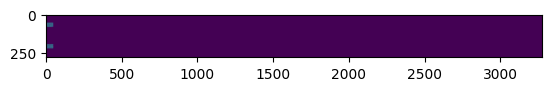

In [29]:
rxGridShape = [2,20,14,3276]
rxSigFreq2 = tf.Variable(tf.zeros(rxGridShape, dtype=tf.complex64))
slotSet = [4,5,14,15]
RBStart = 0
RBSize = 4
subc_indices = slice(RBStart * 12, (RBStart + RBSize) * 12)

puschGridShapePerSlot = [rxGridShape[0], rxGridShape[2], RBSize*12]
for slotIdx in slotSet:
    aaak = tf.complex(tf.random.normal(puschGridShapePerSlot),tf.random.normal(puschGridShapePerSlot))
    rxSigFreq2[:,slotIdx,:,subc_indices].assign(aaak)
print(rxSigFreq2.shape)
plt.imshow(tf.reshape(tf.abs(rxSigFreq2[0]), (20*14,-1)));

In [30]:
rxSigFreq2.shape

TensorShape([2, 20, 14, 3276])

In [31]:
def setRxData(rxSigFreq, dir):
    # rxSigFreq shape (nRx, nSlotInGroup, num_symbols_per_slot, num_subcarriers)
    rxSigFreq = tf.stack((tf.math.real(rxSigFreq), tf.math.imag(rxSigFreq)), axis=-1)
    scaling = tf.math.reduce_max(tf.abs(rxSigFreq))
    rxSigFreq = rxSigFreq / scaling
    
    float2fix = lambda value, frac_bits=13: tf.cast((value * (2 ** frac_bits)),tf.int16)
    rxSigFreq = float2fix(rxSigFreq)
    nRxAnt = rxSigFreq.shape[0]
    for rxIdx in range(nRxAnt):
        file_path = os.path.join(dir, f'rx_ant_{rxIdx}.bin')
        with open(file_path, 'wb') as file:
            file.write(rxSigFreq[rxIdx])
    return scaling    
setRxData(rxSigFreq2, '.')

<tf.Tensor: shape=(), dtype=float32, numpy=4.149262>

In [32]:
def getRxData(dir, rxGridShape):
    # rxSigFreq shape (nRx,L,K)
    # rxSigFreq = tf.Variable(tf.zeros(rxGridShape), dtype=tf.float32)
    nRxAnt = rxGridShape[0]
    rxSigFreq = tf.Variable(tf.zeros(rxGridShape, dtype=tf.complex64))
    fix2float = lambda value, frac_bits=13: tf.cast(value,tf.float32) / (2.**frac_bits)

    for rxIdx in range(nRxAnt):
        file_path = os.path.join(dir, f'rx_ant_{rxIdx}.bin')
        with open(file_path, 'rb') as file:
            ant0 = file.read()
        rxSigInt = tf.reshape(tf.io.decode_raw(ant0, tf.int16),[*rxGridShape[1:],2])
        rxSigFloat = fix2float(rxSigInt)
        rxSigComplex = tf.complex(rxSigFloat[...,0],rxSigFloat[...,1])
        rxSigFreq[rxIdx].assign(rxSigComplex)

    return rxSigFreq

tf.math.reduce_variance(getRxData('.',[2,20,14,3276]) - rxSigFreq2/3.8419538)


<tf.Tensor: shape=(), dtype=float32, numpy=2.1940332e-06>

In [33]:
# We need to enable sionna.config.xla_compat before we can use
# tf.function with jit_compile=True.
# See https://nvlabs.github.io/sionna/api/config.html#sionna.Config.xla_compat
sionna.config.xla_compat=True

class Converter():

    def __init__(self, mode=1):  
        super().__init__()
        # Create a PUSCH configuration with default settings
        pusch_config = PUSCHConfig()

        pusch_config.mapping_type = 'A'
        pusch_config.n_size_bwp = 4
        pusch_config.n_start_bwp = 0
        pusch_config.num_layers = 1
        pusch_config.num_antenna_ports = 1
        pusch_config.precoding = 'non-codebook'
        pusch_config.tpmi = 0
        pusch_config.transform_precoding = False
        pusch_config.n_rnti = 2001

        pusch_config.carrier.cyclic_prefix = "normal"
        pusch_config.carrier.subcarrier_spacing = 30
        pusch_config.carrier.n_cell_id = 500
        pusch_config.carrier.n_size_grid = 273
        pusch_config.carrier.n_start_grid = 0
        # pusch_config.carrier.slot_number = 4

        pusch_config.dmrs.config_type = 1
        pusch_config.dmrs.length = 1
        pusch_config.dmrs.additional_position = 1
        pusch_config.dmrs.dmrs_port_set = [0]
        pusch_config.dmrs.n_id = 0
        pusch_config.dmrs.n_scid = 0
        pusch_config.dmrs.num_cdm_groups_without_data = 2
        pusch_config.dmrs.type_a_position = 2

        pusch_config.tb.channel_type = 'PUSCH'
        pusch_config.tb.n_id = 20
        pusch_config.tb.mcs_table = 1
        pusch_config.tb.mcs_index = 2

        self._pusch_config = pusch_config
        # Instantiate a PUSCHTransmitter from the PUSCHConfig
        self._pusch_transmitter = PUSCHTransmitter(pusch_config)
                
        
        rx_tx_association = np.ones([1, 1], bool)
        stream_management = StreamManagement(rx_tx_association,1)
        
        
     

        detector = MaximumLikelihoodDetector(output="bit",
                                             demapping_method="maxlog",
                                             resource_grid=self._pusch_transmitter.resource_grid,
                                             stream_management=stream_management,
                                             constellation_type="qam",
                                             num_bits_per_symbol=pusch_config.tb.num_bits_per_symbol)
            
        if mode==0:
            self._pusch_receiver = PUSCHReceiver(self._pusch_transmitter,
                                                 mimo_detector=detector,
                                                 channel_estimator="perfect")
        else:
            self._pusch_receiver = PUSCHReceiver(self._pusch_transmitter)
        
        # Configure antenna arrays
        ut_antenna = Antenna(polarization="single",
                     polarization_type="V",
                     antenna_pattern="38.901",
                     carrier_frequency=2.55e9)

        bs_array = AntennaArray(num_rows=1,
                                num_cols=4,
                                polarization="dual",
                                polarization_type="cross",
                                antenna_pattern="38.901",
                                carrier_frequency=2.55e9)
        cdl = CDL("C", 100e-9, 2.55e9, ut_antenna, bs_array, "uplink", min_speed=10)

        self._channel = OFDMChannel(cdl,
                            self._pusch_transmitter.resource_grid,
                            return_channel=True)

    def gen(self, ebno_db, num_slots, dir='../TestVector/case1412'):
        num_slots_per_frame = self._pusch_config.carrier.num_slots_per_frame
        assert num_slots % num_slots_per_frame == 0, 'num_slots must be a multiple of num_slots_per_frame'
        num_frames = num_slots // num_slots_per_frame
        

        slotSetInFrame = tf.constant([4,5,14,15])
        
        
        b = tf.Variable(tf.zeros([1, 1, num_frames, num_slots_per_frame, self._pusch_config.tb_size]))
        b_hat = tf.Variable(tf.zeros([1, 1, num_frames, num_slots_per_frame, self._pusch_config.tb_size]))
        c = tf.Variable(tf.zeros([1, 1, num_frames, num_slots_per_frame, self._pusch_config.num_coded_bits]))
        
        num_subcarriers = self._pusch_config.carrier.n_size_grid*12
        num_symbols_per_slot =  self._pusch_config.carrier.num_symbols_per_slot
        
        x = tf.Variable(tf.zeros([1, 1, 1, num_frames, num_slots_per_frame, num_symbols_per_slot, num_subcarriers], dtype=tf.complex64))
        y = tf.Variable(tf.zeros([1, 1, 8, num_frames, num_slots_per_frame, num_symbols_per_slot, num_subcarriers], dtype=tf.complex64))
        
        for frameIdx in range(num_frames):
            self._pusch_transmitter._pusch_configs[0].carrier.frame_number = frameIdx
            for slotIdx in slotSetInFrame:
                self._pusch_transmitter._pusch_configs[0].carrier.slot_number = slotIdx

                
                x_i, b_i, c_i = self._pusch_transmitter(1, ret=['c'])
                
                n_start_subcarriers = 12*self._pusch_transmitter._pusch_configs[0].n_start_bwp
                n_end_subcarriers = n_start_subcarriers + 12*self._pusch_transmitter._pusch_configs[0].n_size_bwp

                b[:,:,frameIdx,slotIdx,:].assign(b_i)
                c[:,:,frameIdx,slotIdx,:].assign(c_i)
                x[:,:,:,frameIdx,slotIdx,:,n_start_subcarriers:n_end_subcarriers].assign(x_i)

                no = ebnodb2no(ebno_db,
                            self._pusch_transmitter._num_bits_per_symbol,
                            self._pusch_transmitter._target_coderate,
                            self._pusch_transmitter.resource_grid)
                
                y_i, h_i = self._channel([x_i, no])
                y[:,:,:,frameIdx,slotIdx,:,n_start_subcarriers:n_end_subcarriers].assign(y_i)
                if self._pusch_receiver._perfect_csi:
                    b_hat_i = self._pusch_receiver([y_i, h_i, no])
                else:
                    b_hat_i = self._pusch_receiver([y_i, no])
                
                b_hat[:,:,frameIdx,slotIdx,:].assign(b_hat_i)
        
            examplePath = os.path.join(dir,f'Frame{frameIdx:03d}')
            os.makedirs(examplePath, exist_ok=True)

            setCfgReg(self._pusch_transmitter, examplePath, 8, frameIdx, slotSetInFrame)
            setUlCfgReq(self._pusch_transmitter, examplePath, 8, frameIdx, slotSetInFrame)
            set_null(examplePath)
            print(setRxData(y[0,0,:,frameIdx],examplePath))

        return b, b_hat, c, x, y

# b, b_hat, c, x, y = Converter().gen(30.,20)
# print(b.shape, b_hat.shape, c.shape, y.shape)

XLA can lead to reduced numerical precision. Use with care.


In [34]:
def getUlCfg(dir):
    with open(f"{dir}/cfgReq.cfg", "r") as f:  # Replace with your actual file path
        splitted = f.read().split('\n\n')
        test_config = BeautifulSoup(splitted[1], "xml")
        config_req = BeautifulSoup(splitted[2], "xml")
        rx_config = BeautifulSoup(splitted[3], "xml")

    nSlot = int(test_config.find('numSlots').text)
    pusch_config = PUSCHConfig()
    pusch_config.dmrs.type_a_position = int(config_req.find('nDMRSTypeAPos').text)
    pusch_config.carrier.n_cell_id = int(config_req.find('nPhyCellId').text)
    pusch_config.carrier.subcarrier_spacing = 15*2**int(config_req.find('nSubcCommon').text)

    pusch_configs = []
    for slotIdx in range(nSlot):
        slotCfg = rx_config.find(f'SlotNum{slotIdx}').text
        if slotCfg == 'null.cfg':
            pusch_configs.append(None)
        else:
            with open(f"{dir}/{slotCfg}", "r") as f:  # Replace with your actual file path
                ul_config_req = BeautifulSoup(f.read(), "xml")
            pusch_config_i = pusch_config.clone()

            pusch_config_i.carrier.subcarrier_spacing = 15*2**int(ul_config_req.find('nSubcSpacing').text)
            pusch_config_i.carrier.frame_number = int(ul_config_req.find('nSFN').text)
            pusch_config_i.carrier.slot_number = int(ul_config_req.find('nSlot').text)
            pusch_config_i.carrier.n_size_grid = int(ul_config_req.find('nBWPSize').text)
            pusch_config_i.carrier.n_start_grid = int(ul_config_req.find('nBWPStart').text)
            pusch_config_i.carrier.cyclic_prefix = 'normal' if int(ul_config_req.find('nCpType').text) == 0 else 'extended'

            pusch_config_i.n_rnti = int(ul_config_req.find('nRNTI').text)
            pusch_config_i.tpmi = int(ul_config_req.find('nPMI').text)
            pusch_config_i.n_size_bwp = int(ul_config_req.find('nRBSize').text)
            pusch_config_i.n_start_bwp = int(ul_config_req.find('nRBStart').text)
            pusch_config_i.mapping_type = 'A' if int(ul_config_req.find('nMappingType').text) == 0 else 'B'
            pusch_config_i.transform_precoding = bool(int(ul_config_req.find('nTransPrecode').text))
            pusch_config_i.precoding = 'non-codebook' if int(ul_config_req.find('nTransmissionScheme').text) == 0 else 'codebook'
            pusch_config_i.num_layers = int(ul_config_req.find('nNrOfLayers').text)

            pusch_config_i.tb.n_id = int(ul_config_req.find('nNid').text)
            pusch_config_i.tb.mcs_table = int(ul_config_req.find('nMcsTable').text) + 1
            pusch_config_i.tb.mcs_index = int(ul_config_req.find('nMCS').text)
            
            pusch_config_i.dmrs.config_type = int(ul_config_req.find('nDMRSConfigType').text) + 1
            pusch_config_i.dmrs.num_cdm_groups_without_data = int(ul_config_req.find('nNrOfCDMs').text)
            pusch_config_i.dmrs.length = int(ul_config_req.find('nNrOfDMRSSymbols').text)
            pusch_config_i.dmrs.additional_position = int(ul_config_req.find('nDMRSAddPos').text)
            pusch_config_i.dmrs.dmrs_port_set = [0]
            pusch_config_i.dmrs.n_scid = int(ul_config_req.find('nSCID').text)
            pusch_config_i.dmrs.n_id= int(ul_config_req.find('nNIDnSCID').text)

            pusch_configs.append(pusch_config_i)

    return pusch_configs      
getUlCfg('/workspaces/sionna/TestVector/case1412/Frame000')

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [35]:
# # We need to enable sionna.config.xla_compat before we can use
# # tf.function with jit_compile=True.
# # See https://nvlabs.github.io/sionna/api/config.html#sionna.Config.xla_compat
# sionna.config.xla_compat=True

# class Simulator(tf.keras.layers.Layer):
#     def __init__(self, pusch_config, channel_model, mode=1, dir='../Dataset'):
#         super().__init__()
#         # Create a PUSCH configuration with default settings
        
#         self.dir = dir
#         os.makedirs(self.dir, exist_ok=True)
#         self.size = 0

#         self.dirs = {}

#         self._pusch_config = pusch_config

#         self.tb_size = pusch_config.tb_size
#         self.num_coded_bits = pusch_config.num_coded_bits
#         self.num_subcarriers = 12*pusch_config.n_size_bwp
#         self.num_symbols = pusch_config.symbol_allocation[1]
#         # Instantiate a PUSCHTransmitter from the PUSCHConfig
#         self._pusch_transmitter = PUSCHTransmitter(pusch_config)
                
        
#         rx_tx_association = np.ones([1, 1], bool)
#         stream_management = StreamManagement(rx_tx_association,1)   

#         detector = MaximumLikelihoodDetector(output="bit",
#                                              demapping_method="maxlog",
#                                              resource_grid=self._pusch_transmitter.resource_grid,
#                                              stream_management=stream_management,
#                                              constellation_type="qam",
#                                              num_bits_per_symbol=pusch_config.tb.num_bits_per_symbol)
            
#         if mode==0:
#             self._pusch_receiver = PUSCHReceiver(self._pusch_transmitter,
#                                                  mimo_detector=detector,
#                                                  channel_estimator="perfect")
#         else:
#             self._pusch_receiver = PUSCHReceiver(self._pusch_transmitter)
        

#         file_path = os.path.join(f'{self.dir}', f'pusch_transmiter.txt')
#         with open(file_path, 'w') as f:
#             pusch_transmitter.show(f)
    
#         self._channel = OFDMChannel(channel_model,
#                             self._pusch_transmitter.resource_grid,
#                             return_channel=True)

#     def poll(self):
#         existing_samples = {}
#         for no in next(os.walk(self.dir))[1]:
#             existing_samples[no] = os.path.getsize(f'{self.dir}/{no}/b.bin') * 8 // self.tb_size
#         return existing_samples
    
    
#     def call(self, batch_size, ebno_db):
#         no_dir = f'{self.dir}/{ebno_db:03.2f}'
#         os.makedirs(no_dir, exist_ok=True)
#         no = ebnodb2no(ebno_db,
#             self._pusch_transmitter._num_bits_per_symbol,
#             self._pusch_transmitter._target_coderate,
#             self._pusch_transmitter.resource_grid)
#         # File paths
#         bbin = os.path.join(no_dir, 'b.bin')
#         cbin = os.path.join(no_dir, 'c.bin')
#         xbin = os.path.join(no_dir, 'x.bin')
#         hbin = os.path.join(no_dir, 'h.bin')
#         ybin = os.path.join(no_dir, 'y.bin')

#         # Get total stored samples
#         existing_samples = 0
#         if os.path.exists(bbin):
#             existing_samples = os.path.getsize(bbin) * 8 // self.tb_size  # Approximate total stored samples
#         # Get last read position or start from 0
#         print(self.dirs.get(ebno_db, 0))
#         start_idx = self.dirs.get(ebno_db, 0)
    
#         available_samples = existing_samples - start_idx

#         # If next batch is fully available, load it
#         if available_samples >= batch_size:
#             load_size = batch_size
#             generate_size = 0
#         else:
#             # If not enough, load what exists and generate the rest
#             load_size = max(0, available_samples)
#             generate_size = batch_size - load_size

#         # Initialize placeholders
#         b, c, x, h, y = None, None, None, None, None  

#         # Load Data from Dataset if Available
#         if load_size > 0:

#             end_idx = start_idx + load_size
#             self.dirs[ebno_db] = end_idx  # Update read position

#             with open(bbin, "rb") as file:

#                 file.seek(start_idx * self.tb_size // 8)
#                 b = np.unpackbits(np.frombuffer(file.read(load_size * self.tb_size // 8), dtype=np.uint8))
#                 b = b.reshape(load_size, 1, self.tb_size)

                
#             with open(cbin, "rb") as file:
#                 file.seek(start_idx * self.num_coded_bits // 8)
#                 c = np.unpackbits(np.frombuffer(file.read(load_size * self.num_coded_bits // 8), dtype=np.uint8))
#                 c = c.reshape(load_size, 1, self.num_coded_bits)

#             with open(xbin, "rb") as file:
#                 file.seek(start_idx * 1 * 1 * self.num_symbols * self.num_subcarriers * 2 * 2)
#                 x = np.frombuffer(file.read(load_size * self.num_symbols * self.num_subcarriers * 2 * 2), dtype=np.int16)
#                 x = x.reshape(load_size, 1, 1, self.num_symbols, self.num_subcarriers, 2)
#                 x = tf.cast((x[..., 0] + 1j * x[..., 1]) / (2**13), tf.complex64)

#             with open(hbin, "rb") as file:
#                 file.seek(start_idx * 1 * 8 * 1 * 1 * self.num_symbols * self.num_subcarriers * 2 * 2)
#                 h = np.frombuffer(file.read(load_size * 8 * self.num_symbols * self.num_subcarriers * 2 * 2), dtype=np.int16)
#                 h = h.reshape(load_size, 1, 8, 1, 1, self.num_symbols, self.num_subcarriers, 2)
#                 h = tf.cast((h[..., 0] + 1j * h[..., 1]) / (2**13), tf.complex64)

#             with open(ybin, "rb") as file:
#                 file.seek(start_idx * 8 * self.num_symbols * self.num_subcarriers * 2 * 2)
#                 y = np.frombuffer(file.read(load_size * 8 * self.num_symbols * self.num_subcarriers * 2 * 2), dtype=np.int16)
#                 y = y.reshape(load_size, 1, 8, self.num_symbols, self.num_subcarriers, 2)
#                 y = tf.cast((y[..., 0] + 1j * y[..., 1]) / (2**13), tf.complex64)

#         # Generate Remaining Data if Needed
#         if generate_size > 0:
#             end_idx = start_idx + generate_size
#             self.dirs[ebno_db] = end_idx
#             x_gen, b_gen, c_gen = self._pusch_transmitter(generate_size, ret='c')
            
#             y_gen, h_gen = self._channel([x_gen, no])

#             # Combine Loaded & Generated Data
#             if load_size > 0:
#                 b = np.concatenate([b, b_gen], axis=0)
#                 c = np.concatenate([c, c_gen], axis=0)
#                 x = tf.concat([x, x_gen], axis=0)
#                 h = tf.concat([h, h_gen], axis=0)
#                 y = tf.concat([y, y_gen], axis=0)
#             else:
#                 b, c, x, h, y = b_gen, c_gen, x_gen, h_gen, y_gen

#             # Save Generated Data for Future Use
#             with open(bbin, 'ab') as file:
#                 file.write(b2b(b_gen))
#             with open(cbin, 'ab') as file:
#                 file.write(b2b(c_gen))
#             with open(xbin, 'ab') as file:
#                 file.write(f2f(tf.stack((tf.math.real(x_gen), tf.math.imag(x_gen)), axis=-1)))
#             with open(hbin, 'ab') as file:
#                 file.write(f2f(tf.stack((tf.math.real(h_gen), tf.math.imag(h_gen)), axis=-1)))
#             with open(ybin, 'ab') as file:
#                 file.write(f2f(tf.stack((tf.math.real(y_gen), tf.math.imag(y_gen)), axis=-1)))

#         # Pass Through Receiver
#         if self._pusch_receiver._perfect_csi:
#             b_hat = self._pusch_receiver([y, h, no])
#         else:
#             b_hat = self._pusch_receiver([y, no])
#         return b, b_hat

In [39]:
pusch_config = PUSCHConfig()

pusch_config.mapping_type = 'A'
pusch_config.n_size_bwp = 10
pusch_config.n_start_bwp = 0
pusch_config.num_layers = 1
pusch_config.num_antenna_ports = 1
pusch_config.precoding = 'non-codebook'
pusch_config.tpmi = 0
pusch_config.transform_precoding = False
pusch_config.n_rnti = 2001

pusch_config.carrier.cyclic_prefix = "normal"
pusch_config.carrier.subcarrier_spacing = 30
pusch_config.carrier.n_cell_id = 500
pusch_config.carrier.n_size_grid = 273
pusch_config.carrier.n_start_grid = 0
pusch_config.carrier.frame_number = 0
pusch_config.carrier.slot_number = 4

pusch_config.dmrs.config_type = 1
pusch_config.dmrs.length = 1
pusch_config.dmrs.additional_position = 1
pusch_config.dmrs.dmrs_port_set = [0]
pusch_config.dmrs.n_id = 0
pusch_config.dmrs.n_scid = 0
pusch_config.dmrs.num_cdm_groups_without_data = 2
pusch_config.dmrs.type_a_position = 2

pusch_config.tb.channel_type = 'PUSCH'
pusch_config.tb.n_id = 20
pusch_config.tb.mcs_table = 1
pusch_config.tb.mcs_index = 4

In [38]:
# Configure antenna arrays
ut_antenna = Antenna(polarization="single",
                polarization_type="V",
                antenna_pattern="38.901",
                carrier_frequency=2.55e9)

bs_array = AntennaArray(num_rows=1,
                        num_cols=4,
                        polarization="dual",
                        polarization_type="cross",
                        antenna_pattern="38.901",
                        carrier_frequency=2.55e9)
cdl = CDL("C", 150e-9, 2.55e9, ut_antenna, bs_array, "uplink", min_speed=10)

In [ ]:
# We need to enable sionna.config.xla_compat before we can use
# tf.function with jit_compile=True.
# See https://nvlabs.github.io/sionna/api/config.html#sionna.Config.xla_compat
sionna.config.xla_compat=True

class Generator(tf.keras.layers.Layer):
    def __init__(self, pusch_config, channel_model, mode=1, dir='../Dataset'):
        super().__init__()
        # Create a PUSCH configuration with default settings
        self.dir = dir
        os.makedirs(self.dir, exist_ok=True)
        self.size = 0

        self.dirs = {}

        self._pusch_config = pusch_config

        self.tb_size = pusch_config.tb_size
        self.num_coded_bits = pusch_config.num_coded_bits
        self.num_subcarriers = 12*pusch_config.n_size_bwp
        self.num_symbols = pusch_config.symbol_allocation[1]
        # Instantiate a PUSCHTransmitter from the PUSCHConfig
        self._pusch_transmitter = PUSCHTransmitter(pusch_config)
                
        
        rx_tx_association = np.ones([1, 1], bool)
        stream_management = StreamManagement(rx_tx_association,1)   

        detector = MaximumLikelihoodDetector(output="bit",
                                             demapping_method="maxlog",
                                             resource_grid=self._pusch_transmitter.resource_grid,
                                             stream_management=stream_management,
                                             constellation_type="qam",
                                             num_bits_per_symbol=pusch_config.tb.num_bits_per_symbol)
            
        if mode==0:
            self._pusch_receiver = PUSCHReceiver(self._pusch_transmitter,
                                                 mimo_detector=detector,
                                                 channel_estimator="perfect")
        else:
            self._pusch_receiver = PUSCHReceiver(self._pusch_transmitter)
        

        file_path = os.path.join(f'{self.dir}', f'pusch_transmiter.txt')
        with open(file_path, 'w') as f:
            self._pusch_transmitter.show(f)
    
        self._channel = OFDMChannel(channel_model,
                            self._pusch_transmitter.resource_grid,
                            return_channel=True)

        self.save_to_dataset = False

        self.generator = tf.data.Dataset.from_generator(self.load, 
                               output_signature=(
                                tf.TensorSpec(shape=(1, self.tb_size), dtype=tf.float32),
                                tf.TensorSpec(shape=(1, self.tb_size), dtype=tf.float32),
                                tf.TensorSpec(shape=(1, self.num_coded_bits), dtype=tf.float32),
                                tf.TensorSpec(shape=(1, 1, self.num_symbols, self.num_subcarriers), dtype=tf.complex64),
                                tf.TensorSpec(shape=(1, 8, 1, 1, self.num_symbols, self.num_subcarriers), dtype=tf.complex64),
                                tf.TensorSpec(shape=(1, 8, self.num_symbols, self.num_subcarriers), dtype=tf.complex64),
                                tf.TensorSpec(shape=(), dtype=tf.float32),
                                ))

    def poll(self):
        existing_samples = os.path.getsize(f'{self.dir}/b.bin') * 8 // self.tb_size
        return existing_samples
        
    def call(self, batch_size, ebno_db):
        if self.save_to_dataset:
            # no_dir = f'{self.dir}/{ebno_db:03.2f}'
            no_dir = f'{self.dir}'
            os.makedirs(no_dir, exist_ok=True)
        # self.size > 2**16: self.new_dir()
        x, b, c = self._pusch_transmitter(batch_size, ret=['c'])
        # print(x.shape,b.shape,c.shape,x_map.shape, x_layer.shape)            
        no = ebnodb2no(ebno_db,
                    self._pusch_transmitter._num_bits_per_symbol,
                    self._pusch_transmitter._target_coderate,
                    self._pusch_transmitter.resource_grid)
        y, h = self._channel([x, no])
        # print(y.shape, h.shape)
        # self.size += batch_size


        if self.save_to_dataset:
            bbin = os.path.join(f'{no_dir}', f'b.bin')
            with open(bbin, 'ab') as file:
                file.write(b2b(b))

            cbin = os.path.join(f'{no_dir}', f'c.bin')
            with open(cbin, 'ab') as file:
                file.write(b2b(c))

            xbin = os.path.join(f'{no_dir}', f'x.bin')
            with open(xbin, 'ab') as file:
                file.write(f2f(tf.stack((tf.math.real(x), tf.math.imag(x)), axis=-1)))

            hbin = os.path.join(f'{no_dir}', f'h.bin')
            with open(hbin, 'ab') as file:
                file.write(f2f(tf.stack((tf.math.real(h), tf.math.imag(h)), axis=-1)))
                
            ybin = os.path.join(f'{no_dir}', f'y.bin')
            with open(ybin, 'ab') as file:
                file.write(f2f(tf.stack((tf.math.real(y), tf.math.imag(y)), axis=-1)))
            
            batch_no = tf.repeat(no, repeats=batch_size)
            nobin = os.path.join(f'{no_dir}', f'no.bin')
            with open(nobin, 'ab') as file:
                file.write(tf.cast((batch_no * (2 ** 6)), tf.int8))
            
        if self._pusch_receiver._perfect_csi:
            b_hat = self._pusch_receiver([y, h, no])
            # print(compute_ber(b,self._pusch_receiver([yy, hh, no])))
        else:
            b_hat = self._pusch_receiver([y, no])
            # print(compute_ber(b,self._pusch_receiver([yy, no])))

        if self.save_to_dataset:
            b_hatbin = os.path.join(f'{no_dir}', f'b_hat.bin')
            with open(b_hatbin, 'ab') as file:
                file.write(b2b(b_hat))
        return b, b_hat
       
        

    def load(self):
        batch_size = 1
        no_dir = f'{self.dir}'

        with open(os.path.join(no_dir, 'b.bin'), "rb") as bfile, \
                open(os.path.join(no_dir, 'b_hat.bin'), "rb") as b_hatfile, \
                open(os.path.join(no_dir, 'c.bin'), "rb") as cfile, \
                open(os.path.join(no_dir, 'x.bin'), "rb") as xfile, \
                open(os.path.join(no_dir, 'h.bin'), "rb") as hfile, \
                open(os.path.join(no_dir, 'y.bin'), "rb") as yfile, \
                open(os.path.join(no_dir, 'no.bin'), "rb") as nofile:
        
            while True:
                b_batch = np.frombuffer(bfile.read(batch_size * self.tb_size // 8), dtype=np.uint8)
                b_hat_batch = np.frombuffer(b_hatfile.read(batch_size * self.tb_size // 8), dtype=np.uint8)
                c_batch = np.frombuffer(cfile.read(batch_size * self.num_coded_bits // 8), dtype=np.uint8)
                x_batch = np.frombuffer(xfile.read(batch_size * self.num_symbols * self.num_subcarriers * 2 * 2), dtype=np.int16)
                h_batch = np.frombuffer(hfile.read(batch_size * 8 * self.num_symbols * self.num_subcarriers * 2 * 2), dtype=np.int16)
                y_batch = np.frombuffer(yfile.read(batch_size * 8 * self.num_symbols * self.num_subcarriers * 2 * 2), dtype=np.int16)
                no_batch = np.frombuffer(nofile.read(batch_size), dtype=np.int8)

                if not b_batch.size: break  # Stop when reaching the end


                b = tf.cast(np.unpackbits(b_batch).reshape(1, self.tb_size),tf.float32)
                b_hat = tf.cast(np.unpackbits(b_hat_batch).reshape(1, self.tb_size),tf.float32)
                c = tf.cast(np.unpackbits(c_batch).reshape(1, self.num_coded_bits),tf.float32)
                x = (x_batch.reshape(1, 1, self.num_symbols, self.num_subcarriers, 2))
                x = tf.cast((x[..., 0] + 1j * x[..., 1]) / (2**13), tf.complex64)
                h = (h_batch.reshape(1, 8, 1, 1, self.num_symbols, self.num_subcarriers, 2))
                h = tf.cast((h[..., 0] + 1j * h[..., 1]) / (2**13), tf.complex64)
                y = (y_batch.reshape(1, 8, self.num_symbols, self.num_subcarriers, 2))
                y = tf.cast((y[..., 0] + 1j * y[..., 1]) / (2**13), tf.complex64)
                no = tf.cast(no_batch / (2**6), tf.float32)[0]

                yield b, b_hat, c, x, h, y, no
    
    def from_load(self, batch_size):
        for _, (b, _, _, _, h, y, no) in enumerate(self.load(batch_size)):  # Loop through batches
            # print(f"Processing batch {batch_num+1}:", b.shape, c.shape, x.shape, h.shape, y.shape, no.shape)

            # Perform PUSCH reception
            if self._pusch_receiver._perfect_csi:
                b_hat = self._pusch_receiver([y, h, no])
            else:
                b_hat = self._pusch_receiver([y, no])

            # print("BER:", compute_ber(b, b_hat))
            yield b, b_hat  # Yield the batch instead of returning
    
    def from_load_2(self, batch_size):
        
        for _, (b, b_hat, _, _, _, _, _) in enumerate(self.load(batch_size)):  # Loop through batches
            # print(f"Processing batch {batch_num+1}:", b.shape, c.shape, x.shape, h.shape, y.shape, no.shape)

            # print("BER:", compute_ber(b, b_hat))
            yield b, b_hat  # Yield the batch instead of returning

sim = Generator(pusch_config, cdl, dir = '/workspaces/sionna/Dataset/CaseNo/152')


XLA can lead to reduced numerical precision. Use with care.
---- UE 0 ----


In [ ]:
# # We need to enable sionna.config.xla_compat before we can use
# # tf.function with jit_compile=True.
# # See https://nvlabs.github.io/sionna/api/config.html#sionna.Config.xla_compat
# sionna.config.xla_compat=True

# class (tf.keras.Model):
#     def __init__(self, generator):
#         super().__init__()
#         # Create a PUSCH configuration with default settings
#         self.generator = generator
#         self.batch_gen = self.generator.batch():
#     @tf.function(jit_compile=True)    
#     def call(self, batch_size, ebno_db):
#         self.generator
#         if self._pusch_receiver._perfect_csi:
#             b_hat = self._pusch_receiver([y, h, no])
#             # print(compute_ber(b,self._pusch_receiver([yy, hh, no])))
#         else:
#             b_hat = self._pusch_receiver([y, no])
#             # print(compute_ber(b,self._pusch_receiver([yy, no])))

#         return b, b_hat
       
# loader_layer2 = Generator2(pusch_config, cdl,0,'/workspaces/sionna/Dataset/CaseNo/151')

In [81]:
sim.poll()

16

In [86]:
for batch in sim.generator.batch(2):
    print(len(batch))

7
7
7
7
7
7
7
7


We will now compare the PUSCH BLER performance over the 3GPP 38.901 UMi channel model with different detectors and either perfect or imperfect CSI.
Note that these simulations might take some time depending or you available hardware. You can reduce the `batch_size` if the model does not fit into the memory of your GPU. Running the simulations in the time domain will significantly increase the complexity and you might need to decrease the `batch_size` further. The code will also run on CPU if not GPU is available. 

Note that the XLA compilation step can take several minutes, but the simulations will be much faster compared to eager or graph mode.

If you do not want to run the simulation yourself, you can skip the next cell and visualize the results in the next cell.

In [ ]:
class MyPUSCHConfig(PUSCHConfig):
    def __init__(self):
        super().__init__(
            carrier_config=CarrierConfig(
                n_cell_id=500,
                cyclic_prefix="normal",
                subcarrier_spacing=30,
                n_size_grid=273,
                n_start_grid=0,
                slot_number=4,
                frame_number=0
            ),
            pusch_dmrs_config=PUSCHDMRSConfig(
                config_type=1,
                length=1,
                additional_position=1,
                dmrs_port_set=[0],
                n_id=0,
                n_scid=0,
                num_cdm_groups_without_data=2,
                type_a_position=2
            ),
            tb_config=TBConfig(
                channel_type='PUSCH',
                n_id=20,
                mcs_table=1,
                mcs_index=9
            ),
            mapping_type='A',
            n_size_bwp=273,
            n_start_bwp=0,
            num_layers=1,
            num_antenna_ports=1,
            precoding='non-codebook',
            tpmi=0,
            transform_precoding=False,
            n_rnti=2001,
            symbol_allocation=[0,14]
        )

pusch_config_0 = MyPUSCHConfig()
pusch_config_0.show()

In [79]:
PUSCH_SIMS = {
    "bler" : [],
    "ber" : [],
    "cdl": ['A'],
    "delay_spread": [150e-9],
    "speed": [10],
    "RBSize": [100],
    "MCS": [(4,)]
    }

In [ ]:
data_dir = f'../Dataset/{datetime.now().strftime("%Y-%m-%d")}/{datetime.now().strftime("%H-%M-%S")}'
save_to_dataset = True
start = time.time()
caseIdx = 0

for cdl_model in PUSCH_SIMS['cdl']:
    for delay_spread in PUSCH_SIMS['delay_spread']:
        for speed in PUSCH_SIMS['speed']:

            channel_model = CDL(cdl_model, delay_spread, 2.55e9, ut_antenna, bs_array, "uplink", min_speed=speed)
            caseIdx += 1
            channel_dir = f'{data_dir}/CDL{cdl_model}{int(delay_spread*1e9)}-{speed}'
            
            print(dir)
            model = Generator(pusch_config_0, channel_model, mode=0, dir=channel_dir)
            ber, bler = sim_ber(model,
                        np.arange(-8,0.1,0.5),
                        batch_size=128,
                        max_mc_iter=4,
                        num_target_block_errors=512,
                        early_stop=False)
            PUSCH_SIMS["ber"].append(list(ber.numpy()))
            PUSCH_SIMS["bler"].append(list(bler.numpy()))
                    
PUSCH_SIMS["duration"] = time.time() - start

../Dataset/11_2_8_30/CDLC150-10/MCS_4-10_RBs
---- UE 0 ----
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -8.0 | 2.4821e-02 | 9.7656e-02 |       11285 |      454656 |           50 |         512 |        11.5 |reached max iter       
     -7.5 | 1.6778e-02 | 6.4453e-02 |        7628 |      454656 |           33 |         512 |        10.8 |reached max iter       
     -7.0 | 8.3162e-03 | 3.3203e-02 |        3781 |      454656 |           17 |         512 |        11.0 |reached max iter       
     -6.5 | 3.4268e-03 | 1.7578e-02 |        1558 |      454656 |            9 |         512 |        10.9 |reached max iter       
     -6.0 | 5.4789e-03 | 1.9531e-02 |        2491 |      454656 |           10 |         512 |        11.1 |reached max iter       
     -5.5 | 3.0419e-03 | 

In [184]:
data_dir = f'../Dataset/{datetime.now().strftime("%Y-%m-%d")}/{datetime.now().strftime("%H-%M-%S")}'
save_to_dataset = True
start = time.time()
caseIdx = 0

for cdl_model in PUSCH_SIMS['cdl']:
    for delay_spread in PUSCH_SIMS['delay_spread']:
        for speed in PUSCH_SIMS['speed']:

            channel_model = CDL(cdl_model, delay_spread, 2.55e9, ut_antenna, bs_array, "uplink", min_speed=speed)
            caseIdx += 1
            channel_dir = f'{data_dir}/CDL{cdl_model}{int(delay_spread*1e9)}-{speed}'
            
            for n,rbsize in enumerate(PUSCH_SIMS['RBSize']):
                for mcs in PUSCH_SIMS['MCS'][n]:

                    pusch_config_i = pusch_config.clone()
                    pusch_config_i.n_size_bwp = rbsize
                    pusch_config_i.tb.mcs_index = mcs
                    dir = f'{channel_dir}/MCS_{mcs}-{rbsize}_RBs'
                    print(dir)
                    model = Generator(pusch_config_i, channel_model, mode=0, dir=dir)
                    model.save_to_dataset = save_to_dataset
                    ber, bler = sim_ber(model,
                                np.arange(-8,-4.9,0.5),
                                batch_size=8,
                                max_mc_iter=4,
                                num_target_block_errors=32,
                                early_stop=False)
                    PUSCH_SIMS["ber"].append(list(ber.numpy()))
                    PUSCH_SIMS["bler"].append(list(bler.numpy()))
                    
PUSCH_SIMS["duration"] = time.time() - start

../Dataset/2025-02-11/07-17-10/CDLC150-10/MCS_4-10_RBs
---- UE 0 ----
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -8.0 | 0.0000e+00 | 0.0000e+00 |           0 |       28416 |            0 |          32 |         5.4 |reached max iter       
     -7.5 | 1.6892e-02 | 6.2500e-02 |         480 |       28416 |            2 |          32 |         4.5 |reached max iter       
     -7.0 | 0.0000e+00 | 0.0000e+00 |           0 |       28416 |            0 |          32 |         4.6 |reached max iter       
     -6.5 | 5.2787e-04 | 3.1250e-02 |          15 |       28416 |            1 |          32 |         4.5 |reached max iter       
     -6.0 | 0.0000e+00 | 0.0000e+00 |           0 |       28416 |            0 |          32 |         4.5 |reached max iter       
     -5.5 | 0.0

Hopefully you have enjoyed this tutorial on Sionna's 5G NR PUSCH module!

Please have a look at the [API documentation](https://nvlabs.github.io/sionna/api/sionna.html) of the various components or the other available [tutorials](https://nvlabs.github.io/sionna/tutorials.html) to learn more.

In [188]:
start = time.time()
caseIdx = 0

for cdl_model in PUSCH_SIMS['cdl']:
    for delay_spread in PUSCH_SIMS['delay_spread']:
        for speed in PUSCH_SIMS['speed']:

            channel_model = CDL(cdl_model, delay_spread, 2.55e9, ut_antenna, bs_array, "uplink", min_speed=speed)
            caseIdx += 1
            channel_dir = f'{data_dir}/CDL{cdl_model}{int(delay_spread*1e9)}-{speed}'
            
            for n,rbsize in enumerate(PUSCH_SIMS['RBSize']):
                for mcs in PUSCH_SIMS['MCS'][n]:

                    pusch_config_i = pusch_config.clone()
                    pusch_config_i.n_size_bwp = rbsize
                    pusch_config_i.tb.mcs_index = mcs
                    dir = f'{channel_dir}/MCS_{mcs}-{rbsize}_RBs'
                    print(dir)
                    model = Generator(pusch_config_i, channel_model, mode=0, dir=dir)
                    model.save_to_dataset = False
                    qq = model.from_load_2(8)
                    loader_layer = lambda batch_size, ebno_db: next(qq) 
                    # loader_layer = Loader1(model, 16)
                    # loader_layer.loader = loader_layer.loader_2
                    
                    ber, bler = sim_ber(loader_layer,
                                np.arange(-8,-4.9,0.5),
                                batch_size=8,
                                max_mc_iter=4,
                                num_target_block_errors=32,
                                early_stop=False)
                    PUSCH_SIMS["ber"].append(list(ber.numpy()))
                    PUSCH_SIMS["bler"].append(list(bler.numpy()))
                    
PUSCH_SIMS["duration"] = time.time() - start

../Dataset/2025-02-11/07-17-10/CDLC150-10/MCS_4-10_RBs
---- UE 0 ----
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------


     -8.0 | 0.0000e+00 | 0.0000e+00 |           0 |       28416 |            0 |          32 |         0.2 |reached max iter       
     -7.5 | 1.6892e-02 | 6.2500e-02 |         480 |       28416 |            2 |          32 |         0.1 |reached max iter       
     -7.0 | 0.0000e+00 | 0.0000e+00 |           0 |       28416 |            0 |          32 |         0.1 |reached max iter       
     -6.5 | 5.2787e-04 | 3.1250e-02 |          15 |       28416 |            1 |          32 |         0.1 |reached max iter       
     -6.0 | 0.0000e+00 | 0.0000e+00 |           0 |       28416 |            0 |          32 |         0.0 |reached max iter       
     -5.5 | 0.0000e+00 | 0.0000e+00 |           0 |       28416 |            0 |          32 |         0.0 |reached max iter       
     -5.0 | 0.0000e+00 | 0.0000e+00 |           0 |       28416 |            0 |          32 |         0.1 |reached max iter       


In [189]:
start = time.time()
caseIdx = 0

for cdl_model in PUSCH_SIMS['cdl']:
    for delay_spread in PUSCH_SIMS['delay_spread']:
        for speed in PUSCH_SIMS['speed']:

            channel_model = CDL(cdl_model, delay_spread, 2.55e9, ut_antenna, bs_array, "uplink", min_speed=speed)
            caseIdx += 1
            channel_dir = f'{data_dir}/CDL{cdl_model}{int(delay_spread*1e9)}-{speed}'
            
            for n,rbsize in enumerate(PUSCH_SIMS['RBSize']):
                for mcs in PUSCH_SIMS['MCS'][n]:

                    pusch_config_i = pusch_config.clone()
                    pusch_config_i.n_size_bwp = rbsize
                    pusch_config_i.tb.mcs_index = mcs
                    dir = f'{channel_dir}/MCS_{mcs}-{rbsize}_RBs'
                    print(dir)
                    model = Generator(pusch_config_i, channel_model, mode=0, dir=dir)
                    model.save_to_dataset = False
                    qq = model.from_load(8)
                    loader_layer = lambda batch_size, ebno_db: next(qq) 
                    # loader_layer = Loader1(model, 16)
                    # loader_layer.loader = loader_layer.loader_2
                    
                    ber, bler = sim_ber(loader_layer,
                                np.arange(-8,-4.9,0.5),
                                batch_size=8,
                                max_mc_iter=4,
                                num_target_block_errors=32,
                                early_stop=False)
                    PUSCH_SIMS["ber"].append(list(ber.numpy()))
                    PUSCH_SIMS["bler"].append(list(bler.numpy()))
                    
PUSCH_SIMS["duration"] = time.time() - start

../Dataset/2025-02-11/07-17-10/CDLC150-10/MCS_4-10_RBs
---- UE 0 ----
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -8.0 | 4.2230e-04 | 1.2500e-01 |          12 |       28416 |            4 |          32 |         3.6 |reached max iter       
     -7.5 | 4.7825e-02 | 2.8125e-01 |        1359 |       28416 |            9 |          32 |         3.7 |reached max iter       
     -7.0 | 1.6751e-02 | 9.3750e-02 |         476 |       28416 |            3 |          32 |         3.9 |reached max iter       
     -6.5 | 1.0593e-02 | 6.2500e-02 |         301 |       28416 |            2 |          32 |         3.8 |reached max iter       
     -6.0 | 8.4459e-03 | 9.3750e-02 |         240 |       28416 |            3 |          32 |         3.7 |reached max iter       
     -5.5 | 9.1

In [ ]:
for cdl_model in PUSCH_SIMS['cdl']:
    for delay_spread in PUSCH_SIMS['delay_spread']:
        for speed in PUSCH_SIMS['speed']:

            channel_model = CDL(cdl_model, delay_spread, 2.55e9, ut_antenna, bs_array, "uplink", min_speed=speed)
            channel_dir = f'{data_dir}/CDL{cdl_model}{int(delay_spread*1e9)}-{speed}'
            
            for n,rbsize in enumerate(PUSCH_SIMS['RBSize']):
                for mcs in PUSCH_SIMS['MCS'][n]:
                    pusch_config_i = pusch_config.clone()
                    pusch_config_i.n_size_bwp = rbsize
                    pusch_config_i.tb.mcs_index = mcs
                    dir = f'{channel_dir}/MCS_{mcs}-{rbsize}_RBs'
                    print(dir)
                    model = Generator(pusch_config_i, channel_model, mode=0, dir=dir)
                    for batch_num, (b,c,x,h,y,no) in enumerate(model.load(128)):
                        print(f"Processing batch {batch_num + 1}:", b.shape,c.shape,x.shape,h.shape,y.shape, no.shape)
                    

../Dataset/11_2_8_30/CDLC150-10/MCS_4-10_RBs
---- UE 0 ----
Processing batch 1: (128, 1, 888) (128, 1, 2880) (128, 1, 1, 14, 120) (128, 1, 8, 1, 1, 14, 120) (128, 1, 8, 14, 120) (128,)
Processing batch 2: (128, 1, 888) (128, 1, 2880) (128, 1, 1, 14, 120) (128, 1, 8, 1, 1, 14, 120) (128, 1, 8, 14, 120) (128,)
Processing batch 3: (128, 1, 888) (128, 1, 2880) (128, 1, 1, 14, 120) (128, 1, 8, 1, 1, 14, 120) (128, 1, 8, 14, 120) (128,)
Processing batch 4: (128, 1, 888) (128, 1, 2880) (128, 1, 1, 14, 120) (128, 1, 8, 1, 1, 14, 120) (128, 1, 8, 14, 120) (128,)
Processing batch 5: (128, 1, 888) (128, 1, 2880) (128, 1, 1, 14, 120) (128, 1, 8, 1, 1, 14, 120) (128, 1, 8, 14, 120) (128,)
Processing batch 6: (128, 1, 888) (128, 1, 2880) (128, 1, 1, 14, 120) (128, 1, 8, 1, 1, 14, 120) (128, 1, 8, 14, 120) (128,)
Processing batch 7: (128, 1, 888) (128, 1, 2880) (128, 1, 1, 14, 120) (128, 1, 8, 1, 1, 14, 120) (128, 1, 8, 14, 120) (128,)
Processing batch 8: (128, 1, 888) (128, 1, 2880) (128, 1, 1, 14, 